2018 Edition

# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

# The dataset

## File descriptions

* train.csv - the training dataset
* test.csv - the test dataset
* data_description.txt - full description of each column

## Data fields
Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: Value (in dollars) of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale


# Our Notebook

### Textbook material
* “An Introduction to Statistical Learning”, by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
https://link.springer.com/content/pdf/10.1007/978-1-4614-7138-7.pdf
 * Chapter 2, Chapter 3, “Linear Models”
 * Chapter 8, “Tree-based Methods”

### Advanced readings
* “An Introduction to Statistical Learning”, by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
 * Chapter 9, “Support Vector Machines”
* “Gradient Boosting”, WikiPedia
https://en.wikipedia.org/wiki/Gradient_boosting
* “XGBoost: A Scalable Tree Boosting System”, https://arxiv.org/abs/1603.02754
* A video tutorial on XGBoost,
https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/

### Imports

In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
import matplotlib.cm as cm

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate

sqlContext = SQLContext(sc)

challenge_data_folder = "./challenge_data"

from datetime import datetime
from datetime import timedelta
from itertools import islice
import statsmodels.api as sm

from IPython.display import HTML
#Map widget
install = !pip install ipyleaflet
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON, DrawControl, LayerGroup, basemaps
)
install = !pip install geocoder
import geocoder

# !apt-get install ImageMagick #Package to convert images to gif

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Descriptive statistics about the data

In [2]:
pdTrainData = pd.read_csv(challenge_data_folder+"/train.csv",na_filter=False) #Load training data NA filter FALSE to keep Not available data
columnTypesDict = pdTrainData.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [3]:
pdTrainData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [4]:
print("Bedroom" in columnNames) #present in data description but not in training data
print("Kitchen" in columnNames)

False
False


In [5]:
pathDescr = (challenge_data_folder+"/Data description.rtf")
txtDescripData = open(pathDescr).readlines()

In [6]:
columnValues={}
columnIndex=[]
nbHeader = 7
NoHeaderTxtDescripData = txtDescripData[nbHeader:]
for feature in columnNames:
    if feature == 'Id': continue
    for index,line in enumerate(NoHeaderTxtDescripData):
        if feature in line:
            if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                columnIndex.append((feature,index))
            pass

In [7]:
NoSpecificValfeatures = []
SpecificVal = {} #Will contain as keys column names and values the specified values in the description file

for index,featureLine in enumerate(columnIndex):
    
    startLine= featureLine[1]+2
    if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
    else: endLine = columnIndex[index+1][1]-1
    values = []
    if endLine <= startLine: #No specified value in the description file
        if featureLine[0]=='Heating': print(columnIndex[index])
        NoSpecificValfeatures.append(featureLine[0])
        continue
    for i in range(startLine,endLine):
        line =NoHeaderTxtDescripData[i] 
        values.append(line.split('\t')[0].strip())
    SpecificVal[featureLine[0]]=values
    
print(SpecificVal)

{'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'], 'Street': ['Grvl', 'Pave'], 'Alley': ['Grvl', 'Pave', 'NA'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'], 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'BldgType': ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'TwnhsI'],

In [8]:
NoSpecificValfeatures

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

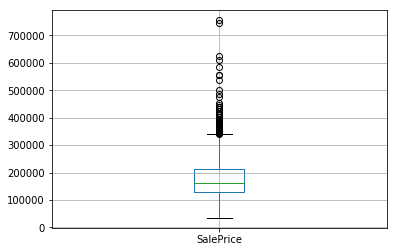

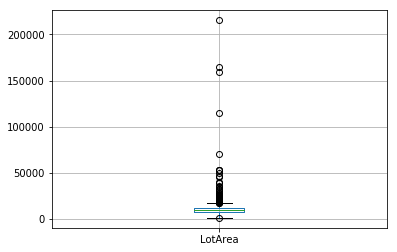

In [9]:
pdTrainData.boxplot(column=["SalePrice"])
plt.show()
pdTrainData.boxplot(column=["LotArea"])
plt.show()

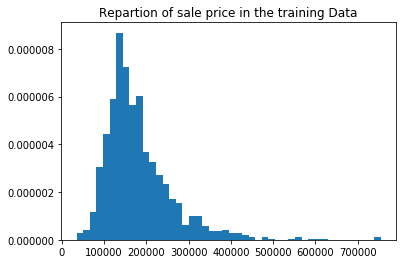

Number of unvalid sample with a sale price <= 0: 0


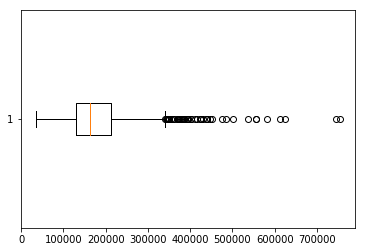

In [10]:
salePrices = pdTrainData.SalePrice.tolist()
plt.hist(salePrices, bins='auto', density=True, cumulative=False)
plt.title("Repartion of sale price in the training Data")

plt.show()
print("Number of unvalid sample with a sale price <= 0:",pdTrainData.SalePrice[pdTrainData.SalePrice<=0].count())

plt.boxplot(salePrices, vert=False)
plt.show()

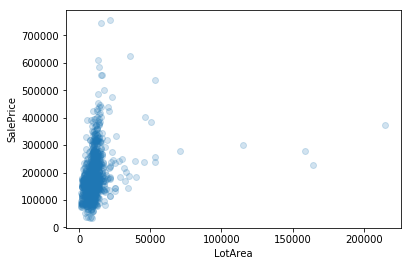

In [11]:
plt.scatter(pdTrainData.LotArea, pdTrainData.SalePrice, alpha=0.2)
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [12]:
pdTrainData[pdTrainData.MSZoning == 'RL'].Id.count()

946

A : 0
C : 0
FV : 55
I : 0
RH : 12
RL : 946
RP : 0
RM : 178


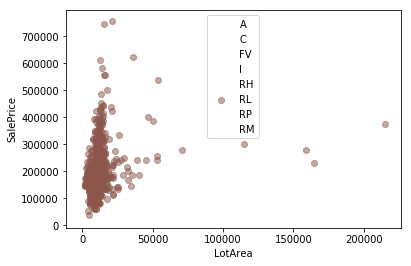

In [13]:
value='RL'

for MSZoningValue in SpecificVal['MSZoning']:
    pdTrainData_MSZoningValue = pdTrainData[pdTrainData.MSZoning == MSZoningValue]
    print(MSZoningValue,':',pdTrainData[pdTrainData.MSZoning == MSZoningValue].Id.count())
    
    if MSZoningValue==value: alpha = 0.5
    else: alpha = 0
        
    plt.scatter(pdTrainData_MSZoningValue.LotArea, pdTrainData_MSZoningValue.SalePrice, alpha=alpha, label=MSZoningValue)
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.legend()
plt.show()

#matplotlib.animation avec une update function

In [14]:
import seaborn as sns
sns.set()
sns.set_style({'legend.frameon':True})
for specVal in SpecificVal['MSZoning']:
    plt.figure(figsize=(12,8))
    plt.subplots_adjust(left = .1)
    plt.scatter(pdTrainData.LotArea,pdTrainData.SalePrice,linewidth=0.5,facecolor='w',alpha =0.2,edgecolor='k')
    for MSZoningValue in SpecificVal['MSZoning']:
        pdTrainData_MSZoningValue = pdTrainData[pdTrainData.MSZoning == MSZoningValue]
        
        if MSZoningValue==specVal: alpha = 0.7
        else: alpha = 0
            
        plt.scatter(pdTrainData_MSZoningValue.LotArea, pdTrainData_MSZoningValue.SalePrice, alpha=alpha, label=MSZoningValue)
        
    plt.xlabel("LotArea")
    ylbl = plt.ylabel("SalePrice")
    lgd = plt.legend()
    filename='temp/step'+str(specVal)+'.png'
    plt.savefig(filename)
    plt.clf()
    plt.close()
    #plt.gca()
!rm temp/*.gif
!convert -delay 100 temp/*.png temp/animated_scatter.gif
!rm temp/*.png
print("OK")

rm: cannot remove ‘temp/*.gif’: No such file or directory
/bin/sh: 1: convert: not found
OK


In [15]:
HTML('<img src="temp/animated_scatter.gif">') # style="width:700px;height:500px">')

### Sale Price versus Area Price

In [16]:
#Neighborhood 89
#NextCategory 117

dicStreetName = {} # Abbreviation : Street name
dicStreetLoc = {} # Abbreviation : location returned by geocoder
for index in range(92,117):
    line = txtDescripData[index]
    line = line.strip()
    line = line.split('\t')
    dicStreetName[line[0]]= line[1][:-1]
    dicStreetLoc[line[0]] = geocoder.google(line[1][:-1]+', Ames')

In [17]:
cmapRdYlGn = cm.get_cmap('RdYlGn')
def calcAreasPrices(pdDF):
    """
    Returns dictionnaire = {"Neigborhood":areaPrice}
    
    """
    dicStreetPriceAreas={}
    def calcAreaPrice(row):
        neighborhood = row.Neighborhood
        try:
            dicStreetPriceAreas[neighborhood] #see if already defined
        except KeyError:
            dicStreetPriceAreas[neighborhood]=[0,0,0]
        dicStreetPriceAreas[neighborhood][0]+=row.SalePrice
        dicStreetPriceAreas[neighborhood][1]+=row.LotArea
    none = pdTrainData.apply(calcAreaPrice,axis=1) #fill the dictionnary
    for place in dicStreetPriceAreas:
        areaPrice = dicStreetPriceAreas[place][0]/dicStreetPriceAreas[place][1]
        dicStreetPriceAreas[place] = areaPrice
    return dicStreetPriceAreas
    #print(dicStreetPriceAreas[neighborhood])
dicStreetPriceAreas = calcAreasPrices(pdTrainData)
print(dicStreetPriceAreas)

{'CollgCr': 20.43893739265472, 'Veenker': 15.133918143832238, 'Crawfor': 16.92658934743337, 'NoRidge': 23.049928679388874, 'Mitchel': 14.23237526116939, 'Somerst': 29.55322320949371, 'NWAmes': 16.49992834611817, 'OldTown': 15.708946967813892, 'BrkSide': 16.910100475938656, 'Sawyer': 13.4242253219904, 'NridgHt': 28.8899788413152, 'NAmes': 14.189682044633944, 'SawyerW': 19.38387882154937, 'IDOTRR': 12.054208428802571, 'MeadowV': 41.25743415463042, 'Edwards': 12.843999136512851, 'Timber': 9.50119128123673, 'Gilbert': 17.19430711971769, 'StoneBr': 29.490541930638102, 'ClearCr': 6.732846177897465, 'NPkVill': 49.569387355646896, 'Blmngtn': 57.70382718760606, 'BrDale': 59.280813815945116, 'SWISU': 17.504403242359622, 'Blueste': 84.61538461538461}


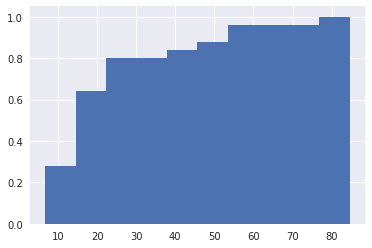

In [18]:
areaPrices = calcAreasPrices(pdTrainData).values()
hist = plt.hist(areaPrices,cumulative=True,normed=True)
plt.show()

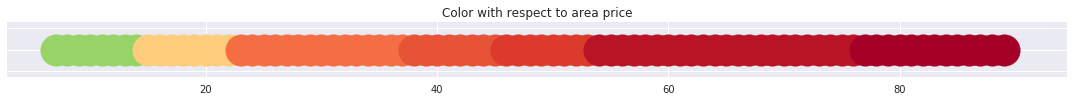

Area Price around Ames


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [19]:
markersList = []
for place in dicStreetPriceAreas:
    coordGeo = dicStreetLoc[place]
    areaPrice = dicStreetPriceAreas[place]
    try:
        lastLowerValuesIndex = list(map(lambda x: x<= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    #colorfloat = (-minAreaPrice)/(maxAreaPrice-minAreaPrice)

    #print(dicStreetPirceArea[place][2],colorfloat)
    markerColor = colors.rgb2hex(cmapRdYlGn(1-colorfloat))#green to red
    marker = CircleMarker(location=(coordGeo.lat, coordGeo.lng), radius=10, color=markerColor, fill_color=markerColor)
    markersList.append(marker)

g = geocoder.google('Ames')
m = Map(center=[g.lat, g.lng], zoom=11)

markersList = [x for x in markersList if x!=None]
group = LayerGroup(layers=markersList)

#PLot color bar
fig,ax = fig, ax = plt.subplots(figsize=(19,1))
plt.title("Color with respect to area price")
minPriceArea,maxPriceArea = 7,90
for areaPrice in np.arange(minPriceArea,maxPriceArea,1):
    try:
        lastLowerValuesIndex = list(map(lambda x: x<= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    plt.scatter(areaPrice,0,c = cmapRdYlGn(1-colorfloat),s=1000)
plt.setp( ax.get_yticklabels(), visible=False)
ax.yaxis.set_ticks_position('none') 
plt.show()

m.add_layer(group)
print("Area Price around Ames")
m



## Data cleaning and pre-processing

In [20]:
pathBadDescr = (challenge_data_folder+"/Bad_Description.rtf")
txtBadDescripData = open(pathBadDescr).readlines()

FileNotFoundError: [Errno 2] No such file or directory: './challenge_data/Bad_Description.rtf'

In [21]:
#Cleaning the data with original data description file:

columnValuesBad={}
columnIndexBad=[]
nbHeader = 7
NoHeaderTxtBadDescripData = txtBadDescripData[nbHeader:]
for feature in columnNames:
    if feature == 'Id': continue
    for index,line in enumerate(NoHeaderTxtBadDescripData):
        if feature in line:
            if(line.split(feature)[0]=='') :
                columnIndexBad.append((feature,index))
            pass
NoSpecificValfeaturesBad = []
SpecificValBad = {} #Will contain as keys column names and values the specified values in the description file

for index,featureLine in enumerate(columnIndexBad):
    startLine= featureLine[1]+2
    if index == len(columnIndexBad)-1: endLine = len(NoHeaderTxtBadDescripData)-1
    else: endLine = columnIndexBad[index+1][1]-1
    values = []
    if endLine <= startLine: #No specified value in the description file
        NoSpecificValfeaturesBad.append(featureLine[0])
        continue
    for i in range(startLine,endLine):
        line =NoHeaderTxtBadDescripData[i] 
        values.append(line.split('\t')[0].strip())
    SpecificValBad[featureLine[0]]=values
    
dicBadValuesBad = []
for factor in SpecificValBad:
    #For a factor search for any value not specified in the description file 
    
    typeCol = columnTypesDict[factor]
    if typeCol == 'int64': valSpec = [int(i) for i in SpecificValBad[factor]]
    else: valSpec = SpecificValBad[factor]
    pdInter = pdTrainData.apply(lambda x: x[factor] not in valSpec,axis=1)
    potentialBadValues = pdTrainData[pdTrainData.apply(lambda x: x[factor] not in valSpec,axis=1)]
    nbBadVal = len(potentialBadValues)
    if nbBadVal>0:
        badValues = [factor]
        badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
        dicBadValuesBad.append(badValues)
dicBadValuesBad


[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}]]

Errors: <br>
Bedroom instead of BedroomAbvGr<br>
Kitchen instead of KitchenAbvGr<br>

In [47]:
#Cleaning the data with fixed description file

#Retrieve Bad values  for the columns with specified values
dicBadValues = []
for factor in SpecificVal:
    
    #For a factor search for any value not specified in the description file 
    #In terms of type of valu
    
    typeCol = columnTypesDict[factor]
    if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
    else: valSpec = SpecificVal[factor]
    pdInter = pdTrainData.apply(lambda x: x[factor] not in valSpec,axis=1)
    potentialBadValues = pdTrainData[pdTrainData.apply(lambda x: x[factor] not in valSpec,axis=1)]
    nbBadVal = len(potentialBadValues)
    
    if nbBadVal>0:
        badValues = [factor]
        badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
        dicBadValues.append(badValues)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}]]

In [49]:
#Retrieve Bad values for the columns with not specified values such as year of construction of 

for feature in NoSpecificValfeatures:
    dtypeColumn = columnTypesDict[feature]
    if dtypeColumn=='float64': typeFun = float
    elif dtypeColumn=='int64': typeFun = int
    pdInter = pdTrainData[pdTrainData.apply(lambda x: x[feature]=='NA',axis=1)]
    if len(pdInter)>0:
        badValues=[feature]
        badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
        dicBadValues.append(badValues)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [30]:
print('When GarageYrBlt = NA, GarageYearType has values ',set(pdTrainData[pdTrainData.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdTrainData[pdTrainData.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageYearType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


# Comment
<div class='alert alert-warning'>
Fixed some errors but some persist <br>
<li>C(all)</li>
<li>Twnhs</li>
Have no direct typo or wrintings<br>
Otherwise the other NA values can be explained by other specified values. The two cases above state that when a property has no garage, the year the garage has been built is not available and no MasVnrType implies no MasVnrArea which is reasonable but important to take into account.<br>


</div>

## Defining a modeling approach to the problem

### A very simple model

The first step is to begin with a really simple model, in order to have first results and write functions to retrieve the data and write the results in the right format. The goal is also to write functions to evaluate the results and test it.
<br>
The first model we will do doesn't take care of "NaN" (=unknown) values because we will only use the lotArea and the neighborhood.
<br>
The idea is to retrieve the mean price per $m^2$ for each neighborhood, and then calculate the price thanks to the lotArea.

In [21]:
print(dicStreetPriceAreas)

In [22]:
pdTData = pd.read_csv(challenge_data_folder+"/train.csv")

In [23]:
pdTData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,346.554469,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,300.750000,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,600.500000,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,900.250000,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1200.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


In [25]:
pdTData[['Neighborhood','LotArea']].groupby('Neighborhood').count()

,LotArea
Neighborhood,
Blmngtn,15
Blueste,2
BrDale,12
BrkSide,45
ClearCr,25
CollgCr,120
Crawfor,40
Edwards,81
Gilbert,67


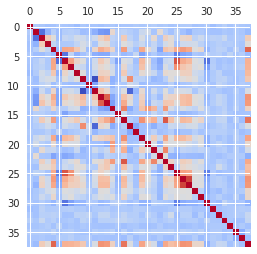

In [28]:
pdTData.cov()
plt.matshow(pdTData.corr(),cmap=plt.cm.coolwarm)

In [32]:
def getTrainValidationData(dataframe, ratioValidation=0.1, numberValidation = None):
    """
    Random splitting into train and validation data, according to the ratio or the number given.
    
    trainData, validationData = getTrainValidationData(dataframe, ratioValidation=0.1)
    """
    if numberValidation == None : numberValidation = int(ratioValidation*len(dataframe))
    if numberValidation > len(dataframe) : numberValidation = len(dataframe)
    if ratioValidation > 1 : ratioValidation = 1
    if ratioValidation < 0 : rationValidation = 0
        
    nbSamples = len(dataframe)
    
    indicesValidation = np.random.choice(nbSamples, numberValidation, replace=False)
    indicesTrain = np.setdiff1d(np.arange(nbSamples), indicesValidation)
    
    return dataframe[indicesTrain], dataframe[indicesValidation]

In [31]:
pdTrainData, pdValidationData = getTrainValidationData(pdAllData, ratioValidation=0.1)

NameError: name 'pdAllData' is not defined

In [ ]:
dictAreasPrices = calcAreasPrices(pdTrainData)

pdValidationData['Id','LotArea','Neighborhood']

# Goal of the challenge

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

## Metric
Notebooks are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Submission File Format
The file should contain a header and have the following format:

```
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

You will find an example submission file within the data directory in the repository.

# Grading the notebook

This challenge is going to be graded as a regular notebook for the AML labs. As a consequence, students should submit:

* the html version of the notebook, using the Data Science Labs submission website, as usual [**Assignement: Challenge Notebook**]
* the submission file (in csv format), that we will use to rank students according to the metric defined above, again through the Data Science Labs submission website [**Assignement: Challenge Predictions**]

In summary, you will have to submit 2 files!